In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='UCIHAR')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6213, 561]),
 torch.Size([1554, 561]),
 torch.Size([6213]),
 torch.Size([1554]))

In [4]:
X_test = X_test[:1000]
y_test = y_test[:1000]

## DNN

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=561, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=12, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.475981  [    0/ 6213]
Epoch 2
-------------------------------
loss: 1.074892  [    0/ 6213]
Epoch 3
-------------------------------
loss: 0.638438  [    0/ 6213]
Epoch 4
-------------------------------
loss: 0.372016  [    0/ 6213]
Epoch 5
-------------------------------
loss: 0.360961  [    0/ 6213]
Epoch 6
-------------------------------
loss: 0.268885  [    0/ 6213]
Epoch 7
-------------------------------
loss: 0.321326  [    0/ 6213]
Epoch 8
-------------------------------
loss: 0.151835  [    0/ 6213]
Epoch 9
-------------------------------
loss: 0.136131  [    0/ 6213]
Epoch 10
-------------------------------
loss: 0.144332  [    0/ 6213]
Epoch 11
-----------------

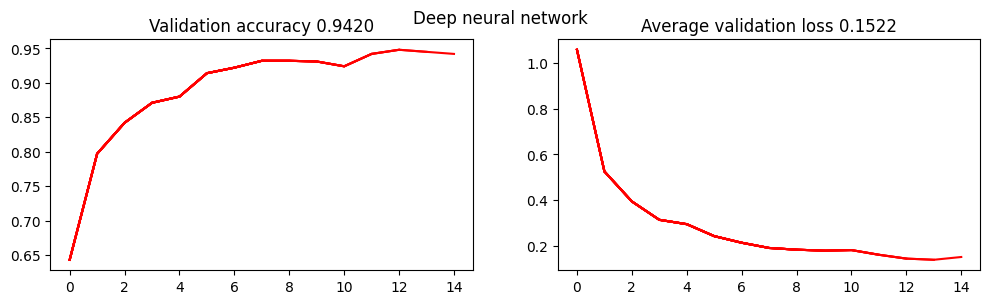

In [6]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomDataset(X_train, y_train, model_type='ffnn')
val_data = DNNmodels.CustomDataset(X_test, y_test, model_type='ffnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features).to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Deep neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    DNNmodels.train(train_dataloader, model_cnn, loss_fn, optimizer)
    DNNmodels.test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    DNNmodels.plot_results(axs, result)

In [7]:
torch.save(model_cnn.state_dict(), './model_dnn_ucihar.pt')

In [5]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_ucihar.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=561, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [6]:
with open('./onlinehd_ucihar.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

In [7]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_dnn, X_train.reshape(len(X_train), features), X_test.reshape(len(X_test), features), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu',
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:00<00:00, 1307.95it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 0.7937295420000012 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 90.50%
mean of norm=0.010000024922192097


100%|██████████| 1000/1000 [00:00<00:00, 1419.05it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 0.7141357919999969 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 84.60%
mean of norm=0.019999990239739418


100%|██████████| 1000/1000 [00:00<00:00, 1412.77it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 0.7178717090000006 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 77.40%
mean of norm=0.030000023543834686


100%|██████████| 1000/1000 [00:00<00:00, 1354.21it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 0.74641175 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 68.60%
mean of norm=0.03999997302889824


100%|██████████| 1000/1000 [00:00<00:00, 1386.74it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 0.7284950830000021 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 58.00%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:00<00:00, 1345.14it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 0.7517421249999998 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 48.70%
mean of norm=0.0599999763071537


100%|██████████| 1000/1000 [00:00<00:00, 1378.71it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 0.7348039589999971 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 40.50%
mean of norm=0.07000002264976501


100%|██████████| 1000/1000 [00:00<00:00, 1386.35it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 0.7298564170000006 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 33.60%
mean of norm=0.07999996095895767


100%|██████████| 1000/1000 [00:00<00:00, 1449.57it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 0.6978940419999979 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 27.20%
mean of norm=0.09000003337860107


100%|██████████| 1000/1000 [00:00<00:00, 1459.77it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 0.6934656669999981 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 22.60%
mean of norm=0.09999995678663254


In [8]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.010000024922192097 0.9229999780654907 0.9049999713897705
0.020000000000000004 0.019999990239739418 0.8949999809265137 0.8460000157356262
0.030000000000000006 0.030000023543834686 0.859000027179718 0.7739999890327454
0.04000000000000001 0.03999997302889824 0.8240000009536743 0.6859999895095825
0.05000000000000001 0.05000000447034836 0.7739999890327454 0.5799999833106995
0.06000000000000001 0.0599999763071537 0.7300000190734863 0.4869999885559082
0.07 0.07000002264976501 0.6930000185966492 0.4050000011920929
0.08 0.07999996095895767 0.6499999761581421 0.335999995470047
0.09000000000000001 0.09000003337860107 0.6169999837875366 0.2720000147819519
0.1 0.09999995678663254 0.5799999833106995 0.22599999606609344


### Deep Fool

In [12]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=max_update, num_classes=classes,
                                                               input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


110.84641790390015
0.01 0.0071259960532188416 0.9190000295639038 0.8939999938011169


100%|██████████| 1000/1000 [01:31<00:00, 10.97it/s]


91.11998510360718
0.02 0.014251991175115108 0.8709999918937683 0.7730000019073486


100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


73.48028612136841
0.03 0.021377988159656525 0.7940000295639038 0.609000027179718


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


56.911927700042725
0.04 0.028503982350230217 0.7099999785423279 0.4429999887943268


100%|██████████| 1000/1000 [00:45<00:00, 21.85it/s]


45.75940203666687
0.05 0.03562998026609421 0.6399999856948853 0.35100001096725464


100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s]


40.24478602409363
0.060000000000000005 0.04275597631931305 0.5820000171661377 0.3019999861717224


100%|██████████| 1000/1000 [00:40<00:00, 24.39it/s]


41.00204801559448
0.06999999999999999 0.04988196864724159 0.5429999828338623 0.2930000126361847


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


56.41167879104614
0.08 0.057007964700460434 0.5009999871253967 0.28700000047683716


100%|██████████| 1000/1000 [00:40<00:00, 24.52it/s]


40.792057037353516
0.09 0.06413397192955017 0.4740000069141388 0.2800000011920929


100%|██████████| 1000/1000 [00:47<00:00, 21.08it/s]


47.43444299697876
0.09999999999999999 0.07125996053218842 0.44200000166893005 0.27399998903274536


100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s]


47.03913187980652
0.11 0.07838596403598785 0.42100000381469727 0.27300000190734863


100%|██████████| 1000/1000 [00:42<00:00, 23.42it/s]


42.698994874954224
0.12 0.0855119526386261 0.40400001406669617 0.2720000147819519


100%|██████████| 1000/1000 [00:39<00:00, 25.61it/s]


39.05077886581421
0.13 0.09263794869184494 0.3880000114440918 0.27000001072883606


100%|██████████| 1000/1000 [00:45<00:00, 21.93it/s]


45.604443073272705
0.14 0.09976393729448318 0.3779999911785126 0.26899999380111694


100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s]


48.76590895652771
0.15000000000000002 0.10688994079828262 0.3630000054836273 0.2680000066757202


100%|██████████| 1000/1000 [00:43<00:00, 22.95it/s]


43.56892704963684
0.16 0.11401592940092087 0.35199999809265137 0.2669999897480011


100%|██████████| 1000/1000 [00:37<00:00, 26.39it/s]


37.88933610916138
0.17 0.12114192545413971 0.33899998664855957 0.2639999985694885


100%|██████████| 1000/1000 [00:38<00:00, 25.66it/s]


38.97437286376953
0.18000000000000002 0.12826794385910034 0.33000001311302185 0.2639999985694885


100%|██████████| 1000/1000 [00:38<00:00, 26.27it/s]


38.071635007858276
0.19 0.1353939324617386 0.32100000977516174 0.2630000114440918


100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


38.572994232177734
0.2 0.14251992106437683 0.3179999887943268 0.2630000114440918


In [13]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=None, num_classes=classes,
                                                           input_dim=features, model_type='dnn')
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]


37.628746032714844
None 0.06552905589342117 0.453000009059906 0.2939999997615814


### Genetic Attack

In [11]:
alpha_lis = np.linspace(0.0004, 0.0037, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_dnn, delta, alpha, x_test_samp.reshape(-1, features), y_test_samp,
                                            input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0004


100%|██████████| 1000/1000 [31:28<00:00,  1.89s/it]


1888.5417249202728
0.0004 0.012236201204359531 0.9359999895095825 0.9399999976158142
Alpha : 0.0005736842105263159


100%|██████████| 1000/1000 [29:16<00:00,  1.76s/it]


1756.9399890899658
0.0005736842105263159 0.017316589131951332 0.9279999732971191 0.9300000071525574
Alpha : 0.0007473684210526316


100%|██████████| 1000/1000 [29:04<00:00,  1.74s/it]


1744.2854731082916
0.0007473684210526316 0.02237147092819214 0.9300000071525574 0.9319999814033508
Alpha : 0.0009210526315789475


100%|██████████| 1000/1000 [28:28<00:00,  1.71s/it]


1708.1794092655182
0.0009210526315789475 0.02723408117890358 0.9229999780654907 0.906000018119812
Alpha : 0.0010947368421052631


100%|██████████| 1000/1000 [28:28<00:00,  1.71s/it]


1708.1220471858978
0.0010947368421052631 0.03200226277112961 0.9169999957084656 0.9089999794960022
Alpha : 0.001268421052631579


100%|██████████| 1000/1000 [28:41<00:00,  1.72s/it]


1721.5269408226013
0.001268421052631579 0.03664891794323921 0.9160000085830688 0.902999997138977
Alpha : 0.0014421052631578947


100%|██████████| 1000/1000 [28:20<00:00,  1.70s/it]


1700.602838754654
0.0014421052631578947 0.04069974273443222 0.9150000214576721 0.8840000033378601
Alpha : 0.0016157894736842104


100%|██████████| 1000/1000 [28:18<00:00,  1.70s/it]


1698.7373077869415
0.0016157894736842104 0.04478374496102333 0.9039999842643738 0.8799999952316284
Alpha : 0.0017894736842105263


100%|██████████| 1000/1000 [28:27<00:00,  1.71s/it]


1707.4390301704407
0.0017894736842105263 0.048726145178079605 0.9039999842643738 0.8759999871253967
Alpha : 0.0019631578947368424


100%|██████████| 1000/1000 [28:25<00:00,  1.71s/it]


1705.713054895401
0.0019631578947368424 0.05185507982969284 0.9160000085830688 0.8880000114440918
Alpha : 0.002136842105263158


100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it]


1713.8784070014954
0.002136842105263158 0.05442839488387108 0.9120000004768372 0.8880000114440918
Alpha : 0.002310526315789474


100%|██████████| 1000/1000 [28:34<00:00,  1.71s/it]


1714.148692369461
0.002310526315789474 0.056588657200336456 0.9100000262260437 0.8920000195503235
Alpha : 0.0024842105263157897


100%|██████████| 1000/1000 [28:22<00:00,  1.70s/it]


1702.4523661136627
0.0024842105263157897 0.058362286537885666 0.9129999876022339 0.8880000114440918
Alpha : 0.0026578947368421056


100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it]


1713.3838300704956
0.0026578947368421056 0.06146494299173355 0.9179999828338623 0.9020000100135803
Alpha : 0.002831578947368421


100%|██████████| 1000/1000 [28:38<00:00,  1.72s/it]


1718.4619069099426
0.002831578947368421 0.0627807155251503 0.9110000133514404 0.8970000147819519
Alpha : 0.003005263157894737


100%|██████████| 1000/1000 [29:04<00:00,  1.74s/it]


1744.658962726593
0.003005263157894737 0.06471946835517883 0.9129999876022339 0.8980000019073486
Alpha : 0.003178947368421053


100%|██████████| 1000/1000 [28:31<00:00,  1.71s/it]


1711.7822132110596
0.003178947368421053 0.06486144661903381 0.9210000038146973 0.9169999957084656
Alpha : 0.003352631578947369


100%|██████████| 1000/1000 [28:42<00:00,  1.72s/it]


1722.8269019126892
0.003352631578947369 0.06695161759853363 0.9190000295639038 0.9169999957084656
Alpha : 0.0035263157894736847


100%|██████████| 1000/1000 [28:40<00:00,  1.72s/it]


1720.129105091095
0.0035263157894736847 0.06636296212673187 0.9160000085830688 0.9210000038146973
Alpha : 0.0037


100%|██████████| 1000/1000 [28:24<00:00,  1.70s/it]


1704.847750902176
0.0037 0.0682026818394661 0.925000011920929 0.9200000166893005
